In [13]:
import obonet
import pandas as pd
import argparse
import logging
import re
import numpy as np
from tqdm import tqdm
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from protnote.utils.configs import load_config,construct_absolute_paths, get_project_root

# Load the configuration and project root
config, project_root = load_config()
results_dir = config["paths"]["output_paths"]["RESULTS_DIR"]
logging.basicConfig(level=logging.INFO)


def calculate_label(row):
    """
    Helper function to calculate the label for a given row.
    Returns the definition of the row with any text between brackets removed.
    """
    definition = row.get("def", None)

    # Remove any text between brackets, e.g., PubMed citations
    # Remove leading and trailing quotation marks
    if definition is not None:
        definition = re.sub(r'\s*\[.*?\]\s*', '', definition)
        definition = definition.strip('"')
        
    return definition

def process_synonyms(row)->dict:
    """extracts the synonyms of a GO Annotation

    :param row: Row of GO annotation dataset
    :type row: _type_
    :return: dict
    :rtype: lists of synonyms for relevant scopes
    """    
    if row is np.nan or not row:
        return {"synonym_exact": [], "synonym_narrow": [], "synonym_related": [], "synonym_broad": []}

    scopes = {"EXACT": [], "NARROW": [], "RELATED": [], "BROAD": []}
    for synonym in row:
        match = re.search(r'\"(.+?)\"\s+(EXACT|NARROW|RELATED|BROAD)\s+\[', synonym)
        if match:
            text, scope = match.groups()
            scopes[scope].append(text)

    return {
        "synonym_exact": scopes["EXACT"],
        "synonym_narrow": scopes["NARROW"],
        "synonym_related": scopes["RELATED"],
        "synonym_broad": scopes["BROAD"]
    }


def download_and_process_obo(url: str):
    """
    Download the OBO file from the specified URL and save the GO ID and label to a pickle.
    """
    logging.info("Downloading and processing OBO file...")

    # Load the .obo file directly from the URL into a networkx graph using obonet
    graph = obonet.read_obo(url, ignore_obsolete=False)

    # Convert the graph nodes (terms) into a pandas dataframe
    df = pd.DataFrame.from_dict(dict(graph.nodes(data=True)), orient='index')

    logging.info("Calculating labels...")
    # Create a new column called "label"
    df["label"] = df.apply(calculate_label, axis=1)

    # Filter the dataframe to retain only 'label', 'name' and 'synonym' columns, with the 'id' column as the index
    df_filtered = df[['label','name']+['is_obsolete']]

    obsolete_labels = set(df_filtered[df_filtered['is_obsolete']=="true"].index)
    used_labels = set(df_filtered.index) - obsolete_labels
    return used_labels,obsolete_labels

/home/samirchar/anaconda3/envs/protein_functions_310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:

with open('Gene Ontology Data Archive.html','r') as handle:
    soup = BeautifulSoup(handle,'html.parser')

#Get all dates from releases during the last 10 years
dates=list(
    filter(lambda date: pd.to_datetime(date,format='%Y-%m-%d')>=pd.to_datetime('2014-06-01'),
        map(
            lambda x: x.get_text()[:-1],
            soup.findAll(lambda tag: tag.name =='a' and 'data-prefix' in tag.attrs)
            )
        )
    )

urls = [f'http://release.geneontology.org/{date}/ontology/go.obo' for date in dates]


prev_used_labels,prev_obsolete_labels = set(),set()

data = {'dates':[],'new_labels':[],'obsolete_labels':[],'used_labels':[]}


In [ ]:

for date,url in tqdm(zip(dates,urls),total=len(urls)):
    used_labels,obsolete_labels = download_and_process_obo(url)
    print(url)
    data['dates'].append(date)

    new_labels = len(used_labels-prev_used_labels)
    obsolete_labels.update(prev_used_labels-used_labels) #augment obslete with other labels that simply don't show up
    new_obsolete_labels = len((obsolete_labels-prev_obsolete_labels))

    data['new_labels'].append(new_labels)
    data['obsolete_labels'].append(new_obsolete_labels)
    data['used_labels'].append(len(used_labels))


    print('new labels = ',new_labels)
    print('new obsolete = ',new_obsolete_labels)
    print('all labels = ',len(used_labels))

    prev_used_labels.update(used_labels)
    prev_obsolete_labels.update(obsolete_labels)


In [7]:
df = pd.DataFrame(data).set_index('dates')
df.index = pd.to_datetime(df.index)
df.to_parquet(results_dir / 'go_annotations_by_release.parquet')

In [14]:
df = pd.read_parquet(results_dir / 'go_annotations_by_release.parquet')

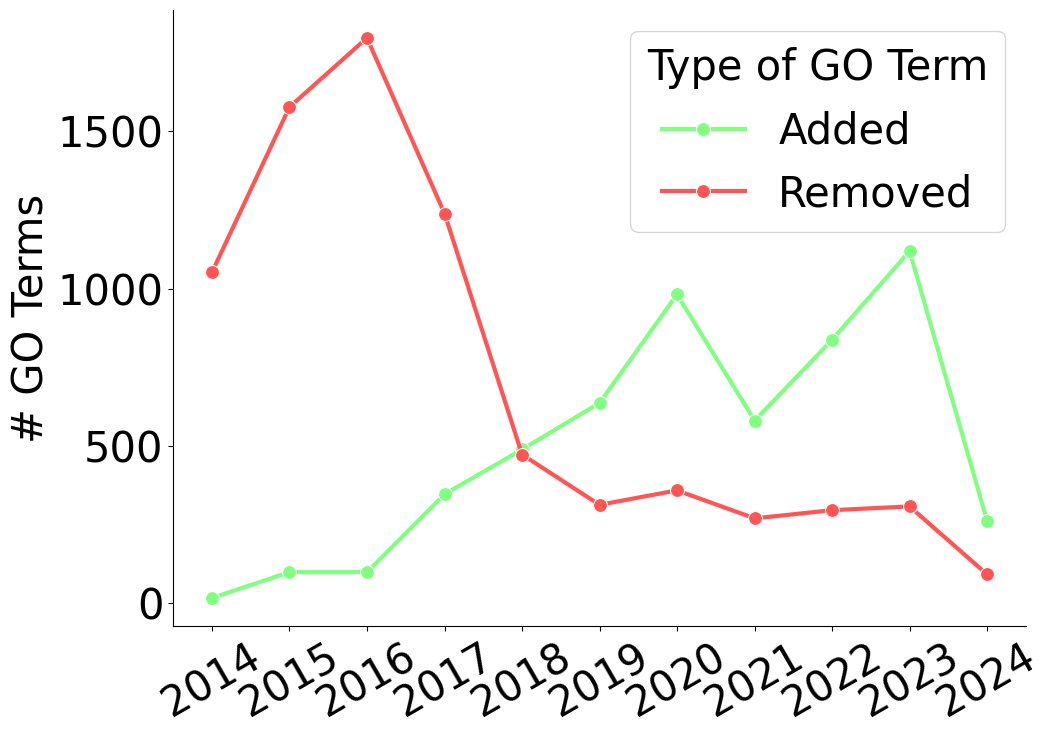

In [16]:
plt.rcParams['font.size'] = 30

df = df.iloc[1:]
fig,ax = plt.subplots(figsize=(11,8))
sns_data = df.groupby([pd.Grouper(level='dates',freq='YS')])[['new_labels','obsolete_labels']]\
    .sum()\
    .melt(ignore_index=False,
          var_name='Type of GO Term',
          value_name='# GO Terms')\
    .replace({'new_labels':'Added','obsolete_labels':'Removed'})

palette = {'Added':'#80ff80','Removed':'#ff5555'}
sns.lineplot(data = sns_data,
             x = 'dates',
             y = '# GO Terms',
             hue='Type of GO Term',
             marker='o',
             palette=palette,
             linewidth=3,
             markersize=10)
plt.xlabel('')
plt.xticks(rotation=30)
sns.despine()
plt.savefig(project_root / 'outputs' / 'figures' / 'deleted_added_go_terms.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()


In [ ]:
for i in a[0].children:
    for j in i:
        print(j)

In [ ]:
soup.find_all('td',class_='sorting_2')

In [ ]:
td_tags = soup.find_all('td', class_='sorting_2')
[td.find('a').get_text() for td in td_tags if td.find('a')]